# Plotting Sonar Scans
Provided functions for plotting of a single sonar scan and printing of some necessary header info
## Dependencies
- matplotlib
- numpy

In [1]:
# imports
import matplotlib.pyplot as plt
import struct
import numpy as np
import os
import math

In [3]:
# raw sonar data file
sonar_filename = "/mnt/Data/Downloads/13_36"
f = open(sonar_filename, 'rb')
d = f.read()

In [4]:
pck_len = struct.unpack('I', d[198:198+4])[0]
pck_num = len(d) // pck_len
print("Number of scans: ", pck_num,"\nLength of a single scan [Bytes]: ", pck_len)

Number of scans:  1193 
Length of a single scan [Bytes]:  326096


In [5]:
# print geometry header info of the scan_n
# n \in [0, Number of Scans - 1]
def print_header(raw_data, n):
    if len(raw_data) < 2048:
        print("No scans to read!")
        return
    len_pack = struct.unpack('I', raw_data[198:198+4])[0]
    num_scans = len(raw_data) // len_pack
    if n > num_scans - 1:
        print("Package number is out of range!")
        return
    p = raw_data[len_pack * n :] 
    print('Length of package [Bytes]: ', struct.unpack('I', p[198:198+4])[0])
    print('Num of Ranges:             ', struct.unpack('H', p[170:170+2])[0])
    print('Num of Beams:              ', struct.unpack('H', p[172:172+2])[0])
    print('Image offset [Bytes]:      ', struct.unpack('H', p[190:190+2])[0])
    print('Min angle [Deg]:           ', struct.unpack('h', p[202:202+2])[0] / 100)
    print('Max angle [Deg]:           ', struct.unpack('h', p[(202 + 
                                                              2 * struct.unpack('H', p[172:172+2])[0]) - 2
                                                              : 202 + 2 + 
                                                             2 * struct.unpack('H', p[172:172+2])[0] - 2])[0] / 100)

    print('Resolution [m]:            ', struct.unpack('d', p[162:170])[0] )
    print('Calc. range [m]:           ', struct.unpack('d', p[162:170])[0] * struct.unpack('H', p[170:170+2])[0])
    print('Ping start time[s]:        ', struct.unpack('d', p[170-17:170-17+8])[0])
    print('Roll [Deg]:                ', struct.unpack('d', p[170-25 - 8*1: 170-25 - 8*0])[0])
    print('Pitch [Deg]:               ', struct.unpack('d', p[170-25 - 8*2:170-25 - 8*1])[0])
    print('Head [Deg]:                ', struct.unpack('d', p[170-25 - 8*3:170-25 - 8*2])[0])

In [6]:
print_header(d, 25) # prints header of scan number 24

Length of package [Bytes]:  326096
Num of Ranges:              628
Num of Beams:               512
Image offset [Bytes]:       2048
Min angle [Deg]:            -20.0
Max angle [Deg]:            20.0
Resolution [m]:             0.00795684351850535
Calc. range [m]:            4.9968977296213595
Ping start time[s]:         14192.042982
Roll [Deg]:                 0.0
Pitch [Deg]:                0.0
Head [Deg]:                 1.625


In [7]:
# plots the scan_n
# n \in [0, Number of Scans - 1]
def plot_scan(raw_data, n, ax = None, fig = None):
    if len(raw_data) < 2048:
        print("No scans to read!")
        return
    len_pack = struct.unpack('I', raw_data[198:198+4])[0]
    num_scans = len(raw_data) // len_pack
    if n > num_scans - 1:
        print("Package number is out of range!")
        return
    p = raw_data[len_pack * n :] 
    
    num_range = struct.unpack('H', p[170:170+2])[0]
    num_beams = struct.unpack('H', p[172:172+2])[0]
    res = struct.unpack('d', p[162:170])[0]
    a = struct.unpack('I', p[198:198+4])[0] * n + struct.unpack('H', p[190:190+2])[0]
    img = np.fromstring(d[a + 4:a+ 4 + num_beams], dtype='uint8')

    for x in range(1,num_range):
       begin = a + (num_beams + 4) * x + 4
       img = np.concatenate([img, np.fromstring(d[begin:begin + num_beams], dtype='uint8')])

    theta = []

    for i in range(num_range):
       for k in range(num_beams):
          theta += [ struct.unpack('h', p[(202 + 2 * k): (202 + 2 * k) + 2])[0] / 100 ]

    r = []

    for k in range(num_range):
       r += [k * res] * num_beams


    x = []
    y = []
    for i in range (num_range * num_beams):
       x += [r[i] * np.cos(np.deg2rad(theta[i]))]
       y += [r[i] * np.sin(np.deg2rad(theta[i]))]

    t = struct.unpack('d', p[170-17:170-17+8])[0]
    t_int = math.floor(t)
    h = t_int // 3600
    m = (t_int - h * 3600) // 60
    s = t_int - h * 3600 - m * 60
    ms = math.floor((t - t_int) * 1000)
    if ax == None:
        plt.figure(figsize=(10, 10))
        plt.scatter(y,x, s=1, c=img, vmin=0, vmax=255)
        plt.colorbar()
        plt.axis('equal')
        plt.title(f"Time since boot up:   {h}H : {m}M : {s}S : {ms}MS")
        plt.show()
    elif fig != None:
        print("Plotted Frame ", n)
        fig.clear()
        ax.clear()
        ax = fig.add_subplot(111, aspect='equal')
        ax.set_title(f"Time since boot up:   {h}H : {m}M : {s}S : {ms}MS")
        s = ax.scatter(y,x, s=1, c=img, vmin=0, vmax=255)
        fig.colorbar(s)

Length of package [Bytes]:  326096
Num of Ranges:              628
Num of Beams:               512
Image offset [Bytes]:       2048
Min angle [Deg]:            -20.0
Max angle [Deg]:            20.0
Resolution [m]:             0.00795684351850535
Calc. range [m]:            4.9968977296213595
Ping start time[s]:         14231.550668
Roll [Deg]:                 0.0
Pitch [Deg]:                0.0
Head [Deg]:                 1.625


/tmp/ipykernel_81737/4067403770.py:18: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  img = np.fromstring(d[a + 4:a+ 4 + num_beams], dtype='uint8')
/tmp/ipykernel_81737/4067403770.py:22: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  img = np.concatenate([img, np.fromstring(d[begin:begin + num_beams], dtype='uint8')])


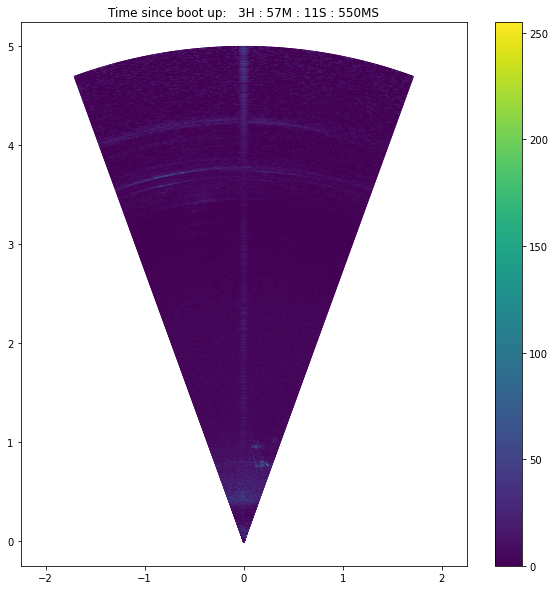

In [10]:
print_header(d, 420)
plot_scan(d, 420)

In [ ]:
# Saves a gif animation of scans ## 260 - 280

import matplotlib.animation as animation

out_filename = "sonar_readings.gif"
fig, ax = plt.subplots(figsize=(10, 10))

def animate(i):
    plot_scan(d, 260 + i, ax, fig)

ani = animation.FuncAnimation(fig, animate, interval=100, frames=20)
ani.save(out_filename, writer="pillow", savefig_kwargs=dict(facecolor='#FFFFFF'))

In [2]:
from scipy.signal import medfilt

from skimage import data
from skimage import filters
from skimage import exposure

from skimage.morphology import disk
from skimage.filters import rank

In [104]:
scan_id = 404

In [75]:
raw_data = d

In [76]:
len_pack = struct.unpack('I', raw_data[198:198+4])[0]
num_scans = len(raw_data) // len_pack
if scan_id > num_scans - 1:
    print("Package number is out of range!")
p = raw_data[len_pack * scan_id:] 

In [134]:
num_range = struct.unpack('H', p[170:170+2])[0]
num_beams = struct.unpack('H', p[172:172+2])[0]
res = struct.unpack('d', p[162:170])[0]
a = struct.unpack('I', p[198:198+4])[0] * scan_id + struct.unpack('H', p[190:190+2])[0]
img = np.fromstring(p[a + 4:a+ 4 + num_beams], dtype='uint8').reshape(1,512)

/tmp/ipykernel_81737/1208341149.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  img = np.fromstring(p[a + 4:a+ 4 + num_beams], dtype='uint8')


In [135]:
img.shape

(512,)

In [79]:
img

array([[40, 41, 43, 46, 46, 44, 41, 39, 39, 38, 38, 38, 35, 30, 26, 21,
        20, 21, 23, 24, 25, 25, 21, 20, 15, 16, 13, 11, 13, 14, 11,  9,
        16, 20, 23, 20, 18, 17, 14, 14, 11, 10, 11,  9, 11, 14, 16, 16,
        14, 14, 15, 16, 14, 14, 19, 22, 23, 22, 21, 19, 18, 17, 16, 16,
        16, 15, 16, 12, 14, 16, 13, 13, 15, 14, 16, 15, 16, 18, 18, 16,
        16, 17, 17, 16, 19, 16, 16, 16, 18, 18, 16, 14, 12, 14, 14, 13,
         9,  5,  9,  7,  8, 11,  9,  2,  8, 11, 14, 16, 16, 17, 14, 14,
        14, 15, 16, 15, 17, 17, 15, 11,  5, 10,  9, 10, 11, 14, 15, 14,
        13, 11, 13, 14, 16, 16, 16, 14, 16, 19, 22, 23, 20, 19, 18, 19,
        21, 22, 22, 20, 16, 16, 18, 19, 19, 18, 15,  8, 12, 16, 18, 16,
        13, 14, 19, 22, 23, 22, 20, 15, 15, 19, 23, 24, 22, 18, 19, 24,
        26, 27, 23, 13, 14, 24, 28, 31, 31, 30, 29, 27, 25, 27, 29, 30,
        30, 29, 34, 41, 46, 48, 46, 43, 39, 37, 37, 40, 44, 48, 52, 53,
        53, 53, 53, 54, 56, 58, 58, 56, 53, 50, 48, 48, 48, 51, 

In [107]:

for x in range(0,num_range):
    begin = a + (num_beams + 4) * x + 4
    #img = np.concatenate([img, np.fromstring(p[begin:begin + num_beams], dtype='uint8')])
    img = np.append(img, [np.fromstring(p[begin:begin + num_beams], dtype='uint8')], axis=0)

/tmp/ipykernel_81737/1073432289.py:4: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  img = np.append(img, [np.fromstring(p[begin:begin + num_beams], dtype='uint8')], axis=0)


In [81]:
img.shape

(629, 512)

In [82]:
from matplotlib import pyplot as plt

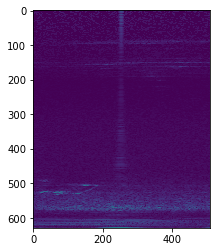

In [108]:
plt.imshow(np.flip(img), interpolation='nearest')
plt.show()

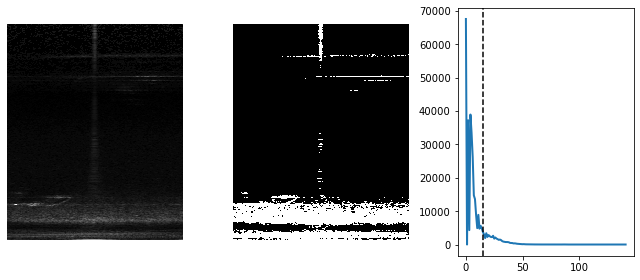

In [119]:
med = medfilt(img, [3,3])
val = filters.threshold_otsu(med)
           
hist, bins_center = exposure.histogram(med)

plt.figure(figsize=(9, 4))
plt.subplot(131)
plt.imshow(np.flip(med), cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(132)
plt.imshow(np.flip(med) > val, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(133)
plt.plot(bins_center, hist, lw=2)
plt.axvline(val, color='k', ls='--')

plt.tight_layout()
plt.show()

In [3]:
import time

In [ ]:
def compute_avg(raw_data):
    if len(raw_data) < 2048:
        print("No scans to read!")
        return
    len_pack = struct.unpack('I', raw_data[198:198+4])[0]
    num_scans = len(raw_data) // len_pack
    

In [4]:
class SonarData:
    def __init__(self, filename):
        self.filename = filename
        self.f = open(self.filename, 'rb')
        self.data = self.f.read()
        self.pck_len = struct.unpack('I', self.data[198:198+4])[0]
        self.pck_num = len(self.data) // self.pck_len
        self.num_range = struct.unpack('H', self.data[170:170+2])[0]
        self.num_beams = struct.unpack('H', self.data[172:172+2])[0]
        self.img_offset = struct.unpack('H', self.data[190:190+2])[0]
        self.res = struct.unpack('d', self.data[162:170])[0]
        self.range = self.res * self.num_range
        angles = []
        for i in range(self.num_beams):
            angles += [ struct.unpack('h', self.data[202 + 2 * i: 204 + 2 * i])[0] / 100 ]
        self.angles = np.array(angles)
        self.last_time = struct.unpack('d', self.data[(self.pck_num - 1) * self.pck_len + 153: (self.pck_num - 1) * self.pck_len + 161])[0]
        self.time_mod = os.path.getmtime(self.filename)
        self.bootup_time = self.time_mod - self.last_time
        
        self.sonar_array = None
        total_time = 0.0
        sonar_times = []
        # Asssuming 4 bytes of gain for every range
        for scan_id in range(self.pck_num):#range(self.pck_num):
            start = time.time()
            sonar_times += [ self.bootup_time + struct.unpack('d', self.data[scan_id * self.pck_len + 153: scan_id * self.pck_len + 161])[0] ]
            a = self.pck_len * scan_id + self.img_offset
            img = np.fromstring(self.data[a + 4:a+ 4 + self.num_beams], dtype='uint8')
            for x in range(1, self.num_range):
                begin = a + (self.num_beams + 4) * x + 4
                img = np.vstack((img, np.fromstring(self.data[begin:begin + self.num_beams], dtype='uint8')))
            if self.sonar_array is None:
                self.sonar_array = np.copy(img).reshape(1,self.num_range,self.num_beams)
            else:
                self.sonar_array = np.append(self.sonar_array, img.reshape(1,self.num_range,self.num_beams), axis = 0)
                print(self.sonar_array.shape)
            end = time.time()
            proc_time = round(end - start,2)
            print("SonarData :: Parsed ", scan_id + 1, " / ", self.pck_num,' in ', proc_time,' s')
            total_time += proc_time
        self.sonar_times = np.array(sonar_times)
        print("Initialized ", self.filename, " with ", self.pck_num, " packages in ", int(total_time) // 60, "m ", int(total_time) % 60,"s")

In [5]:
A = SonarData("/mnt/Data/Downloads/13_36")

/tmp/ipykernel_60564/333642208.py:29: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  img = np.fromstring(self.data[a + 4:a+ 4 + self.num_beams], dtype='uint8')
/tmp/ipykernel_60564/333642208.py:32: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  img = np.vstack((img, np.fromstring(self.data[begin:begin + self.num_beams], dtype='uint8')))


SonarData :: Parsed  1  /  1193  in  0.03  s
(2, 628, 512)
SonarData :: Parsed  2  /  1193  in  0.01  s
(3, 628, 512)
SonarData :: Parsed  3  /  1193  in  0.01  s
(4, 628, 512)
SonarData :: Parsed  4  /  1193  in  0.01  s
(5, 628, 512)
SonarData :: Parsed  5  /  1193  in  0.02  s
(6, 628, 512)
SonarData :: Parsed  6  /  1193  in  0.01  s
(7, 628, 512)
SonarData :: Parsed  7  /  1193  in  0.01  s
(8, 628, 512)
SonarData :: Parsed  8  /  1193  in  0.02  s
(9, 628, 512)
SonarData :: Parsed  9  /  1193  in  0.02  s
(10, 628, 512)
SonarData :: Parsed  10  /  1193  in  0.01  s
(11, 628, 512)
SonarData :: Parsed  11  /  1193  in  0.01  s
(12, 628, 512)
SonarData :: Parsed  12  /  1193  in  0.01  s
(13, 628, 512)
SonarData :: Parsed  13  /  1193  in  0.01  s
(14, 628, 512)
SonarData :: Parsed  14  /  1193  in  0.02  s
(15, 628, 512)
SonarData :: Parsed  15  /  1193  in  0.02  s
(16, 628, 512)
SonarData :: Parsed  16  /  1193  in  0.02  s
(17, 628, 512)
SonarData :: Parsed  17  /  1193  in  0.0

(136, 628, 512)
SonarData :: Parsed  136  /  1193  in  0.02  s
(137, 628, 512)
SonarData :: Parsed  137  /  1193  in  0.02  s
(138, 628, 512)
SonarData :: Parsed  138  /  1193  in  0.03  s
(139, 628, 512)
SonarData :: Parsed  139  /  1193  in  0.02  s
(140, 628, 512)
SonarData :: Parsed  140  /  1193  in  0.02  s
(141, 628, 512)
SonarData :: Parsed  141  /  1193  in  0.02  s
(142, 628, 512)
SonarData :: Parsed  142  /  1193  in  0.02  s
(143, 628, 512)
SonarData :: Parsed  143  /  1193  in  0.02  s
(144, 628, 512)
SonarData :: Parsed  144  /  1193  in  0.02  s
(145, 628, 512)
SonarData :: Parsed  145  /  1193  in  0.02  s
(146, 628, 512)
SonarData :: Parsed  146  /  1193  in  0.03  s
(147, 628, 512)
SonarData :: Parsed  147  /  1193  in  0.03  s
(148, 628, 512)
SonarData :: Parsed  148  /  1193  in  0.02  s
(149, 628, 512)
SonarData :: Parsed  149  /  1193  in  0.02  s
(150, 628, 512)
SonarData :: Parsed  150  /  1193  in  0.03  s
(151, 628, 512)
SonarData :: Parsed  151  /  1193  in  

(269, 628, 512)
SonarData :: Parsed  269  /  1193  in  0.03  s
(270, 628, 512)
SonarData :: Parsed  270  /  1193  in  0.03  s
(271, 628, 512)
SonarData :: Parsed  271  /  1193  in  0.03  s
(272, 628, 512)
SonarData :: Parsed  272  /  1193  in  0.03  s
(273, 628, 512)
SonarData :: Parsed  273  /  1193  in  0.03  s
(274, 628, 512)
SonarData :: Parsed  274  /  1193  in  0.03  s
(275, 628, 512)
SonarData :: Parsed  275  /  1193  in  0.03  s
(276, 628, 512)
SonarData :: Parsed  276  /  1193  in  0.03  s
(277, 628, 512)
SonarData :: Parsed  277  /  1193  in  0.03  s
(278, 628, 512)
SonarData :: Parsed  278  /  1193  in  0.03  s
(279, 628, 512)
SonarData :: Parsed  279  /  1193  in  0.03  s
(280, 628, 512)
SonarData :: Parsed  280  /  1193  in  0.03  s
(281, 628, 512)
SonarData :: Parsed  281  /  1193  in  0.03  s
(282, 628, 512)
SonarData :: Parsed  282  /  1193  in  0.03  s
(283, 628, 512)
SonarData :: Parsed  283  /  1193  in  0.03  s
(284, 628, 512)
SonarData :: Parsed  284  /  1193  in  

(404, 628, 512)
SonarData :: Parsed  404  /  1193  in  0.04  s
(405, 628, 512)
SonarData :: Parsed  405  /  1193  in  0.04  s
(406, 628, 512)
SonarData :: Parsed  406  /  1193  in  0.04  s
(407, 628, 512)
SonarData :: Parsed  407  /  1193  in  0.04  s
(408, 628, 512)
SonarData :: Parsed  408  /  1193  in  0.05  s
(409, 628, 512)
SonarData :: Parsed  409  /  1193  in  0.05  s
(410, 628, 512)
SonarData :: Parsed  410  /  1193  in  0.05  s
(411, 628, 512)
SonarData :: Parsed  411  /  1193  in  0.04  s
(412, 628, 512)
SonarData :: Parsed  412  /  1193  in  0.04  s
(413, 628, 512)
SonarData :: Parsed  413  /  1193  in  0.04  s
(414, 628, 512)
SonarData :: Parsed  414  /  1193  in  0.04  s
(415, 628, 512)
SonarData :: Parsed  415  /  1193  in  0.05  s
(416, 628, 512)
SonarData :: Parsed  416  /  1193  in  0.05  s
(417, 628, 512)
SonarData :: Parsed  417  /  1193  in  0.05  s
(418, 628, 512)
SonarData :: Parsed  418  /  1193  in  0.04  s
(419, 628, 512)
SonarData :: Parsed  419  /  1193  in  

(535, 628, 512)
SonarData :: Parsed  535  /  1193  in  0.04  s
(536, 628, 512)
SonarData :: Parsed  536  /  1193  in  0.04  s
(537, 628, 512)
SonarData :: Parsed  537  /  1193  in  0.04  s
(538, 628, 512)
SonarData :: Parsed  538  /  1193  in  0.04  s
(539, 628, 512)
SonarData :: Parsed  539  /  1193  in  0.05  s
(540, 628, 512)
SonarData :: Parsed  540  /  1193  in  0.06  s
(541, 628, 512)
SonarData :: Parsed  541  /  1193  in  0.06  s
(542, 628, 512)
SonarData :: Parsed  542  /  1193  in  0.06  s
(543, 628, 512)
SonarData :: Parsed  543  /  1193  in  0.06  s
(544, 628, 512)
SonarData :: Parsed  544  /  1193  in  0.06  s
(545, 628, 512)
SonarData :: Parsed  545  /  1193  in  0.04  s
(546, 628, 512)
SonarData :: Parsed  546  /  1193  in  0.04  s
(547, 628, 512)
SonarData :: Parsed  547  /  1193  in  0.04  s
(548, 628, 512)
SonarData :: Parsed  548  /  1193  in  0.04  s
(549, 628, 512)
SonarData :: Parsed  549  /  1193  in  0.05  s
(550, 628, 512)
SonarData :: Parsed  550  /  1193  in  

(668, 628, 512)
SonarData :: Parsed  668  /  1193  in  0.05  s
(669, 628, 512)
SonarData :: Parsed  669  /  1193  in  0.06  s
(670, 628, 512)
SonarData :: Parsed  670  /  1193  in  0.05  s
(671, 628, 512)
SonarData :: Parsed  671  /  1193  in  0.05  s
(672, 628, 512)
SonarData :: Parsed  672  /  1193  in  0.06  s
(673, 628, 512)
SonarData :: Parsed  673  /  1193  in  0.05  s
(674, 628, 512)
SonarData :: Parsed  674  /  1193  in  0.05  s
(675, 628, 512)
SonarData :: Parsed  675  /  1193  in  0.05  s
(676, 628, 512)
SonarData :: Parsed  676  /  1193  in  0.06  s
(677, 628, 512)
SonarData :: Parsed  677  /  1193  in  0.08  s
(678, 628, 512)
SonarData :: Parsed  678  /  1193  in  0.08  s
(679, 628, 512)
SonarData :: Parsed  679  /  1193  in  0.08  s
(680, 628, 512)
SonarData :: Parsed  680  /  1193  in  0.06  s
(681, 628, 512)
SonarData :: Parsed  681  /  1193  in  0.06  s
(682, 628, 512)
SonarData :: Parsed  682  /  1193  in  0.08  s
(683, 628, 512)
SonarData :: Parsed  683  /  1193  in  

(802, 628, 512)
SonarData :: Parsed  802  /  1193  in  0.06  s
(803, 628, 512)
SonarData :: Parsed  803  /  1193  in  0.06  s
(804, 628, 512)
SonarData :: Parsed  804  /  1193  in  0.06  s
(805, 628, 512)
SonarData :: Parsed  805  /  1193  in  0.06  s
(806, 628, 512)
SonarData :: Parsed  806  /  1193  in  0.06  s
(807, 628, 512)
SonarData :: Parsed  807  /  1193  in  0.06  s
(808, 628, 512)
SonarData :: Parsed  808  /  1193  in  0.06  s
(809, 628, 512)
SonarData :: Parsed  809  /  1193  in  0.06  s
(810, 628, 512)
SonarData :: Parsed  810  /  1193  in  0.07  s
(811, 628, 512)
SonarData :: Parsed  811  /  1193  in  0.06  s
(812, 628, 512)
SonarData :: Parsed  812  /  1193  in  0.06  s
(813, 628, 512)
SonarData :: Parsed  813  /  1193  in  0.06  s
(814, 628, 512)
SonarData :: Parsed  814  /  1193  in  0.06  s
(815, 628, 512)
SonarData :: Parsed  815  /  1193  in  0.06  s
(816, 628, 512)
SonarData :: Parsed  816  /  1193  in  0.06  s
(817, 628, 512)
SonarData :: Parsed  817  /  1193  in  

(933, 628, 512)
SonarData :: Parsed  933  /  1193  in  0.07  s
(934, 628, 512)
SonarData :: Parsed  934  /  1193  in  0.09  s
(935, 628, 512)
SonarData :: Parsed  935  /  1193  in  0.1  s
(936, 628, 512)
SonarData :: Parsed  936  /  1193  in  0.08  s
(937, 628, 512)
SonarData :: Parsed  937  /  1193  in  0.07  s
(938, 628, 512)
SonarData :: Parsed  938  /  1193  in  0.06  s
(939, 628, 512)
SonarData :: Parsed  939  /  1193  in  0.06  s
(940, 628, 512)
SonarData :: Parsed  940  /  1193  in  0.07  s
(941, 628, 512)
SonarData :: Parsed  941  /  1193  in  0.07  s
(942, 628, 512)
SonarData :: Parsed  942  /  1193  in  0.07  s
(943, 628, 512)
SonarData :: Parsed  943  /  1193  in  0.07  s
(944, 628, 512)
SonarData :: Parsed  944  /  1193  in  0.07  s
(945, 628, 512)
SonarData :: Parsed  945  /  1193  in  0.07  s
(946, 628, 512)
SonarData :: Parsed  946  /  1193  in  0.07  s
(947, 628, 512)
SonarData :: Parsed  947  /  1193  in  0.07  s
(948, 628, 512)
SonarData :: Parsed  948  /  1193  in  0

(1062, 628, 512)
SonarData :: Parsed  1062  /  1193  in  0.09  s
(1063, 628, 512)
SonarData :: Parsed  1063  /  1193  in  0.08  s
(1064, 628, 512)
SonarData :: Parsed  1064  /  1193  in  0.1  s
(1065, 628, 512)
SonarData :: Parsed  1065  /  1193  in  0.26  s
(1066, 628, 512)
SonarData :: Parsed  1066  /  1193  in  0.09  s
(1067, 628, 512)
SonarData :: Parsed  1067  /  1193  in  0.08  s
(1068, 628, 512)
SonarData :: Parsed  1068  /  1193  in  0.08  s
(1069, 628, 512)
SonarData :: Parsed  1069  /  1193  in  0.08  s
(1070, 628, 512)
SonarData :: Parsed  1070  /  1193  in  0.1  s
(1071, 628, 512)
SonarData :: Parsed  1071  /  1193  in  0.12  s
(1072, 628, 512)
SonarData :: Parsed  1072  /  1193  in  0.08  s
(1073, 628, 512)
SonarData :: Parsed  1073  /  1193  in  0.07  s
(1074, 628, 512)
SonarData :: Parsed  1074  /  1193  in  0.08  s
(1075, 628, 512)
SonarData :: Parsed  1075  /  1193  in  0.09  s
(1076, 628, 512)
SonarData :: Parsed  1076  /  1193  in  0.11  s
(1077, 628, 512)
SonarData 

(1190, 628, 512)
SonarData :: Parsed  1190  /  1193  in  0.48  s
(1191, 628, 512)
SonarData :: Parsed  1191  /  1193  in  0.27  s
(1192, 628, 512)
SonarData :: Parsed  1192  /  1193  in  0.26  s
(1193, 628, 512)
SonarData :: Parsed  1193  /  1193  in  0.14  s
Initialized  /mnt/Data/Downloads/13_36  with  1193  packages in  1 m  9 s


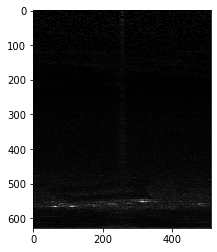

In [174]:
plt.imshow(np.flipud(A.sonar_array[0]), interpolation='nearest',vmin=0, vmax=255)
plt.show()

In [114]:
avg = np.copy(A.sonar_array[0]).astype(np.float64)
for i in range(1,A.pck_num):
    avg = np.add(avg, A.sonar_array[i].astype(np.float64))
AVG = avg.astype(np.float64) * (1/A.pck_num)

In [117]:
np.flip(AVG.astype(int))

array([[ 5,  4,  4, ...,  4,  5,  5],
       [ 5,  4,  4, ...,  5,  5,  5],
       [ 6,  5,  5, ...,  5,  5,  5],
       ...,
       [11,  9,  9, ..., 12, 12, 12],
       [17, 14, 15, ..., 21, 22, 21],
       [38, 33, 30, ..., 44, 42, 41]])

2.0827060305023086


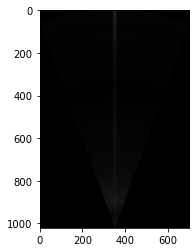

In [123]:
wand_img = Image.from_array(np.flip(AVG.astype(np.uint8)), channel_map = 'I')
wand_img.background_color = Color('black')
wand_img.virtual_pixel = 'background'
args = (
    A.angles[-1] - A.angles[0],  # ArcAngle
    0,   # RotateAngle
    1020,
    1
)
wand_img.distort('arc', args)
display(wand_img)
AVG_c = np.array(wand_img)
AVG_c = AVG_c.reshape(image.shape[0], image.shape[1])

print(AVG_c.mean())
plt.imshow((AVG_c), interpolation='nearest',vmin=0, vmax=255)
plt.show()

In [129]:
AVG_c

37

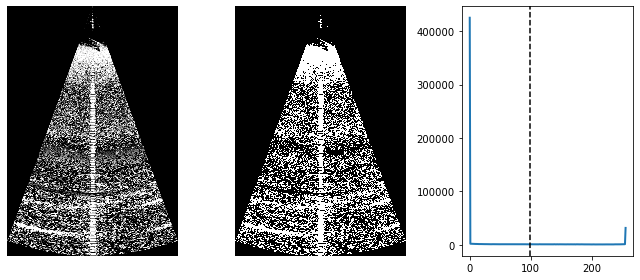

In [80]:
wand_img = Image.from_array(np.flip(A.sonar_array[04]), channel_map = 'I')
wand_img.background_color = Color('black')
wand_img.virtual_pixel = 'background'
args = (
    A.angles[-1] - A.angles[0],  # ArcAngle
    0,   # RotateAngle
    1020,
    1
)
wand_img.distort('arc', args)
image = np.array(wand_img)
image = image.reshape(image.shape[0], image.shape[1])

med = medfilt(image,[3,3])
val = filters.threshold_otsu(med)
           
hist, bins_center = exposure.histogram(med)

plt.figure(figsize=(9, 4))
plt.subplot(131)
plt.imshow(np.flip(med), cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(132)
plt.imshow(np.flip(med) > 50, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(133)
plt.plot(bins_center, hist, lw=2)
plt.axvline(val, color='k', ls='--')

plt.tight_layout()
plt.show()

(1021, 700)


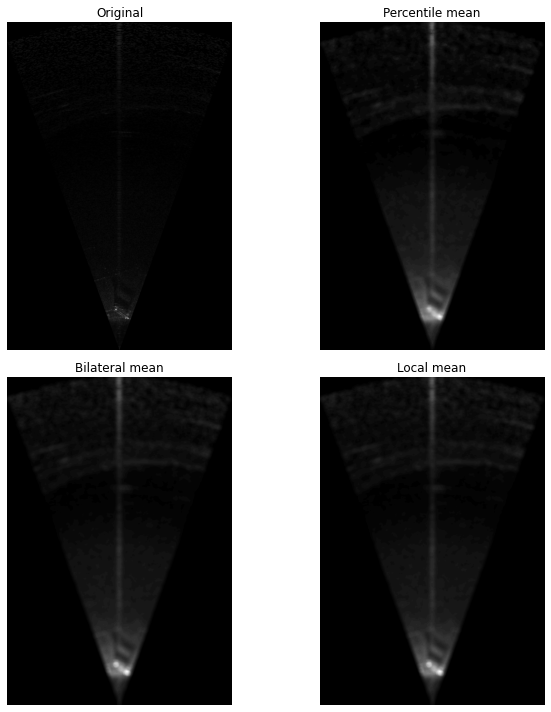

In [164]:
wand_img = Image.from_array(np.flip(A.sonar_array[0]), channel_map = 'I')
wand_img.background_color = Color('black')
wand_img.virtual_pixel = 'background'
args = (
    A.angles[-1] - A.angles[0],  # ArcAngle
    0,   # RotateAngle
    1020,
    1
)
wand_img.distort('arc', args)
image = np.array(wand_img)
image = image.reshape(image.shape[0], image.shape[1])
print(image.shape)
wand_img.destroy()

footprint = disk(9)

percentile_result = rank.mean_percentile(
    image, selem=footprint, p0=.1, p1=.9
)
bilateral_result = rank.mean_bilateral(
    image, selem=footprint, s0=500, s1=500
)
normal_result = rank.mean(image, selem=footprint)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10),
                         sharex=True, sharey=True)
ax = axes.ravel()

titles = ['Original', 'Percentile mean', 'Bilateral mean', 'Local mean']
imgs = [image, percentile_result, bilateral_result, normal_result]
for n in range(0, len(imgs)):
    ax[n].imshow(imgs[n], cmap=plt.cm.gray)
    ax[n].set_title(titles[n])
    ax[n].axis('off')

plt.tight_layout()
plt.show()

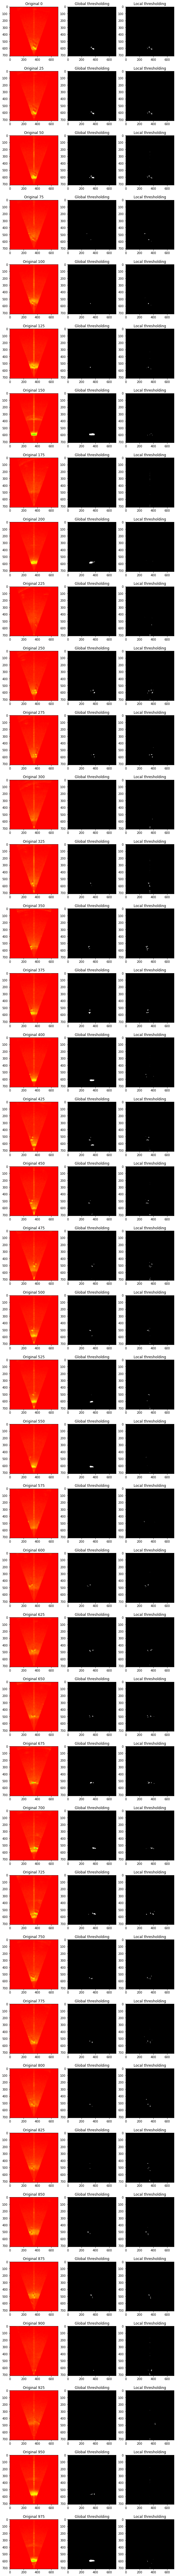

In [163]:
fig, axes = plt.subplots(ncols=3, nrows=40, figsize=(10, 160))
ax = axes.ravel()
plt.gray()

AVG_d = AVG_c[round(AVG_c.shape[0] * 0.3) : AVG_c.shape[0]][:]
for i in range(40):
    wand_img = Image.from_array(np.flip(A.sonar_array[i * 25]), channel_map = 'I')
    wand_img.background_color = Color('black')
    wand_img.virtual_pixel = 'background'
    args = (
        A.angles[-1] - A.angles[0],  # ArcAngle
        0,   # RotateAngle
        1020,
        1
    )
    wand_img.distort('arc', args)
    image = np.array(wand_img)
    image = image.reshape(image.shape[0], image.shape[1])
    
    image = image[round(image.shape[0] * 0.3) : image.shape[0]][:]
    
    footprint = disk(5)

    image = rank.mean_bilateral(
        image, selem=footprint, s0=500, s1=500
    )
    
    MAX = image.max().max()
    MEAN = np.mean(image)
    STD = np.std(image)
    global_thresh = MEAN*0.8 + 6 * STD + AVG_d *0.7
    binary_global = image > global_thresh

    block_size = 13
    local_thresh = filters.threshold_local(image, block_size, offset=-1.2*STD, method = 'median')
    binary_local = image > local_thresh

    ax[i * 3].imshow(image,vmin=0, vmax=255, cmap='hsv')
    ax[i * 3].set_title('Original ' + str(i * 25))

    ax[i * 3 + 1].imshow(binary_global)
    ax[i * 3 + 1].set_title('Global thresholding')

    ax[i * 3 + 2].imshow(binary_local)
    ax[i * 3 + 2].set_title('Local thresholding')

plt.show()

In [293]:
def compute_binarization(sonar_data):
    output = None
    args = (
        sonar_data.angles[-1] - sonar_data.angles[0],  # ArcAngle
        0,   # RotateAngle
        1020,
        1
    )
    footprint = disk(5)
    block_size = 13
    used_percentage = 0.8
    res = -1
    total_time = 0.0
    for i in range(sonar_data.pck_num):
        start = time.time()
        wand_img = Image.from_array(np.flipud(sonar_data.sonar_array[i]), channel_map = 'I')
        wand_img.background_color = Color('black')
        wand_img.virtual_pixel = 'background'
        wand_img.distort('arc', args)
        image = np.flipud(np.array(wand_img))
        image = image.reshape(image.shape[0], image.shape[1])
        if res == -1:
            res = A.range / image.shape[0]
        image = image[0 : math.floor(image.shape[0] * used_percentage)][:]
        image = rank.mean_bilateral(
            image, selem=footprint, s0=500, s1=500
        )
        #plt.imshow(image)
        #plt.show()
        std = np.std(image)
        local_thresh = filters.threshold_local(image, block_size, offset=-1.2*std, method = 'median')
        binary_local = image > local_thresh
        
        if output is None:
            output = np.copy(binary_local).reshape(1,binary_local.shape[0], binary_local.shape[1])
        else:
            output = np.append(output, binary_local.reshape(1,binary_local.shape[0], binary_local.shape[1]), axis = 0)
        end = time.time()
        proc_time = round(end - start,2)
        total_time += proc_time
        print(output.shape, "Binarized ",i,'/',sonar_data.pck_num,' packages in ',proc_time)
        #plt.imshow(binary_local)
        #plt.show()
    print("Binarized ",sonar_data.pck_num," packages in ", int(total_time) // 60, "m ", int(total_time) % 60,"s")
    return (output, res)

In [294]:
out, res = compute_binarization(A)

(1, 816, 700) Binarized  0 / 1193  packages in  1.07
(2, 816, 700) Binarized  1 / 1193  packages in  1.07
(3, 816, 700) Binarized  2 / 1193  packages in  1.01
(4, 816, 700) Binarized  3 / 1193  packages in  1.0
(5, 816, 700) Binarized  4 / 1193  packages in  0.98
(6, 816, 700) Binarized  5 / 1193  packages in  1.0
(7, 816, 700) Binarized  6 / 1193  packages in  1.01
(8, 816, 700) Binarized  7 / 1193  packages in  1.0
(9, 816, 700) Binarized  8 / 1193  packages in  0.99
(10, 816, 700) Binarized  9 / 1193  packages in  1.04
(11, 816, 700) Binarized  10 / 1193  packages in  0.98
(12, 816, 700) Binarized  11 / 1193  packages in  0.98
(13, 816, 700) Binarized  12 / 1193  packages in  1.1
(14, 816, 700) Binarized  13 / 1193  packages in  1.13
(15, 816, 700) Binarized  14 / 1193  packages in  0.98
(16, 816, 700) Binarized  15 / 1193  packages in  0.98
(17, 816, 700) Binarized  16 / 1193  packages in  1.03
(18, 816, 700) Binarized  17 / 1193  packages in  0.96
(19, 816, 700) Binarized  18 / 11

(149, 816, 700) Binarized  148 / 1193  packages in  1.05
(150, 816, 700) Binarized  149 / 1193  packages in  1.04
(151, 816, 700) Binarized  150 / 1193  packages in  1.11
(152, 816, 700) Binarized  151 / 1193  packages in  1.07
(153, 816, 700) Binarized  152 / 1193  packages in  1.04
(154, 816, 700) Binarized  153 / 1193  packages in  1.07
(155, 816, 700) Binarized  154 / 1193  packages in  1.1
(156, 816, 700) Binarized  155 / 1193  packages in  1.08
(157, 816, 700) Binarized  156 / 1193  packages in  1.05
(158, 816, 700) Binarized  157 / 1193  packages in  1.08
(159, 816, 700) Binarized  158 / 1193  packages in  1.3
(160, 816, 700) Binarized  159 / 1193  packages in  1.11
(161, 816, 700) Binarized  160 / 1193  packages in  1.12
(162, 816, 700) Binarized  161 / 1193  packages in  1.08
(163, 816, 700) Binarized  162 / 1193  packages in  1.08
(164, 816, 700) Binarized  163 / 1193  packages in  1.05
(165, 816, 700) Binarized  164 / 1193  packages in  1.14
(166, 816, 700) Binarized  165 / 

(294, 816, 700) Binarized  293 / 1193  packages in  1.5
(295, 816, 700) Binarized  294 / 1193  packages in  1.65
(296, 816, 700) Binarized  295 / 1193  packages in  1.52
(297, 816, 700) Binarized  296 / 1193  packages in  1.45
(298, 816, 700) Binarized  297 / 1193  packages in  1.49
(299, 816, 700) Binarized  298 / 1193  packages in  1.3
(300, 816, 700) Binarized  299 / 1193  packages in  1.43
(301, 816, 700) Binarized  300 / 1193  packages in  1.35
(302, 816, 700) Binarized  301 / 1193  packages in  1.45
(303, 816, 700) Binarized  302 / 1193  packages in  1.27
(304, 816, 700) Binarized  303 / 1193  packages in  1.3
(305, 816, 700) Binarized  304 / 1193  packages in  1.2
(306, 816, 700) Binarized  305 / 1193  packages in  1.39
(307, 816, 700) Binarized  306 / 1193  packages in  1.72
(308, 816, 700) Binarized  307 / 1193  packages in  1.25
(309, 816, 700) Binarized  308 / 1193  packages in  1.22
(310, 816, 700) Binarized  309 / 1193  packages in  1.46
(311, 816, 700) Binarized  310 / 11

(438, 816, 700) Binarized  437 / 1193  packages in  1.21
(439, 816, 700) Binarized  438 / 1193  packages in  1.14
(440, 816, 700) Binarized  439 / 1193  packages in  1.17
(441, 816, 700) Binarized  440 / 1193  packages in  1.18
(442, 816, 700) Binarized  441 / 1193  packages in  1.24
(443, 816, 700) Binarized  442 / 1193  packages in  1.1
(444, 816, 700) Binarized  443 / 1193  packages in  1.21
(445, 816, 700) Binarized  444 / 1193  packages in  1.21
(446, 816, 700) Binarized  445 / 1193  packages in  1.48
(447, 816, 700) Binarized  446 / 1193  packages in  1.55
(448, 816, 700) Binarized  447 / 1193  packages in  1.19
(449, 816, 700) Binarized  448 / 1193  packages in  1.11
(450, 816, 700) Binarized  449 / 1193  packages in  1.2
(451, 816, 700) Binarized  450 / 1193  packages in  1.21
(452, 816, 700) Binarized  451 / 1193  packages in  1.19
(453, 816, 700) Binarized  452 / 1193  packages in  1.24
(454, 816, 700) Binarized  453 / 1193  packages in  1.2
(455, 816, 700) Binarized  454 / 1

(583, 816, 700) Binarized  582 / 1193  packages in  1.24
(584, 816, 700) Binarized  583 / 1193  packages in  1.34
(585, 816, 700) Binarized  584 / 1193  packages in  1.37
(586, 816, 700) Binarized  585 / 1193  packages in  1.34
(587, 816, 700) Binarized  586 / 1193  packages in  1.32
(588, 816, 700) Binarized  587 / 1193  packages in  1.24
(589, 816, 700) Binarized  588 / 1193  packages in  1.25
(590, 816, 700) Binarized  589 / 1193  packages in  1.36
(591, 816, 700) Binarized  590 / 1193  packages in  1.24
(592, 816, 700) Binarized  591 / 1193  packages in  1.27
(593, 816, 700) Binarized  592 / 1193  packages in  1.34
(594, 816, 700) Binarized  593 / 1193  packages in  1.41
(595, 816, 700) Binarized  594 / 1193  packages in  1.41
(596, 816, 700) Binarized  595 / 1193  packages in  1.24
(597, 816, 700) Binarized  596 / 1193  packages in  1.33
(598, 816, 700) Binarized  597 / 1193  packages in  1.26
(599, 816, 700) Binarized  598 / 1193  packages in  1.32
(600, 816, 700) Binarized  599 

(727, 816, 700) Binarized  726 / 1193  packages in  1.14
(728, 816, 700) Binarized  727 / 1193  packages in  1.18
(729, 816, 700) Binarized  728 / 1193  packages in  1.15
(730, 816, 700) Binarized  729 / 1193  packages in  1.05
(731, 816, 700) Binarized  730 / 1193  packages in  1.12
(732, 816, 700) Binarized  731 / 1193  packages in  1.09
(733, 816, 700) Binarized  732 / 1193  packages in  1.25
(734, 816, 700) Binarized  733 / 1193  packages in  1.11
(735, 816, 700) Binarized  734 / 1193  packages in  1.19
(736, 816, 700) Binarized  735 / 1193  packages in  1.09
(737, 816, 700) Binarized  736 / 1193  packages in  1.09
(738, 816, 700) Binarized  737 / 1193  packages in  1.06
(739, 816, 700) Binarized  738 / 1193  packages in  1.29
(740, 816, 700) Binarized  739 / 1193  packages in  1.24
(741, 816, 700) Binarized  740 / 1193  packages in  1.11
(742, 816, 700) Binarized  741 / 1193  packages in  1.08
(743, 816, 700) Binarized  742 / 1193  packages in  1.16
(744, 816, 700) Binarized  743 

(871, 816, 700) Binarized  870 / 1193  packages in  1.22
(872, 816, 700) Binarized  871 / 1193  packages in  1.1
(873, 816, 700) Binarized  872 / 1193  packages in  1.22
(874, 816, 700) Binarized  873 / 1193  packages in  1.07
(875, 816, 700) Binarized  874 / 1193  packages in  1.18
(876, 816, 700) Binarized  875 / 1193  packages in  1.06
(877, 816, 700) Binarized  876 / 1193  packages in  1.25
(878, 816, 700) Binarized  877 / 1193  packages in  1.14
(879, 816, 700) Binarized  878 / 1193  packages in  1.28
(880, 816, 700) Binarized  879 / 1193  packages in  1.13
(881, 816, 700) Binarized  880 / 1193  packages in  1.2
(882, 816, 700) Binarized  881 / 1193  packages in  1.14
(883, 816, 700) Binarized  882 / 1193  packages in  1.32
(884, 816, 700) Binarized  883 / 1193  packages in  1.15
(885, 816, 700) Binarized  884 / 1193  packages in  1.52
(886, 816, 700) Binarized  885 / 1193  packages in  1.16
(887, 816, 700) Binarized  886 / 1193  packages in  1.4
(888, 816, 700) Binarized  887 / 1

(1015, 816, 700) Binarized  1014 / 1193  packages in  1.28
(1016, 816, 700) Binarized  1015 / 1193  packages in  1.11
(1017, 816, 700) Binarized  1016 / 1193  packages in  1.11
(1018, 816, 700) Binarized  1017 / 1193  packages in  1.12
(1019, 816, 700) Binarized  1018 / 1193  packages in  1.18
(1020, 816, 700) Binarized  1019 / 1193  packages in  1.15
(1021, 816, 700) Binarized  1020 / 1193  packages in  1.09
(1022, 816, 700) Binarized  1021 / 1193  packages in  1.24
(1023, 816, 700) Binarized  1022 / 1193  packages in  1.07
(1024, 816, 700) Binarized  1023 / 1193  packages in  1.49
(1025, 816, 700) Binarized  1024 / 1193  packages in  1.47
(1026, 816, 700) Binarized  1025 / 1193  packages in  1.18
(1027, 816, 700) Binarized  1026 / 1193  packages in  1.21
(1028, 816, 700) Binarized  1027 / 1193  packages in  1.15
(1029, 816, 700) Binarized  1028 / 1193  packages in  1.11
(1030, 816, 700) Binarized  1029 / 1193  packages in  1.16
(1031, 816, 700) Binarized  1030 / 1193  packages in  1.

(1155, 816, 700) Binarized  1154 / 1193  packages in  1.26
(1156, 816, 700) Binarized  1155 / 1193  packages in  1.23
(1157, 816, 700) Binarized  1156 / 1193  packages in  1.29
(1158, 816, 700) Binarized  1157 / 1193  packages in  1.24
(1159, 816, 700) Binarized  1158 / 1193  packages in  1.24
(1160, 816, 700) Binarized  1159 / 1193  packages in  1.51
(1161, 816, 700) Binarized  1160 / 1193  packages in  1.32
(1162, 816, 700) Binarized  1161 / 1193  packages in  1.34
(1163, 816, 700) Binarized  1162 / 1193  packages in  1.22
(1164, 816, 700) Binarized  1163 / 1193  packages in  1.22
(1165, 816, 700) Binarized  1164 / 1193  packages in  1.22
(1166, 816, 700) Binarized  1165 / 1193  packages in  1.59
(1167, 816, 700) Binarized  1166 / 1193  packages in  1.22
(1168, 816, 700) Binarized  1167 / 1193  packages in  1.2
(1169, 816, 700) Binarized  1168 / 1193  packages in  1.35
(1170, 816, 700) Binarized  1169 / 1193  packages in  1.52
(1171, 816, 700) Binarized  1170 / 1193  packages in  1.2

In [295]:
res * out[0].shape[0]

3.993602886749294

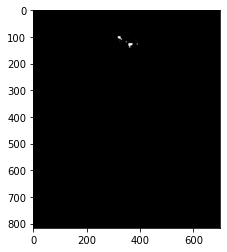

In [311]:
plt.imshow(out[47])
plt.show()

4
3
2
1


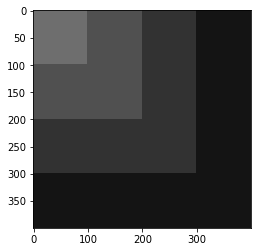

(1021, 1022, 1)


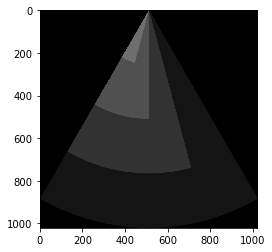

In [222]:
test = np.zeros((400, 400))
for i in range(4,0,-1):
    print(i)
    for x in range(0, i*100):
        for y in range(0, i*100):
            test[x][y] = (4-i)*30+20
            
plt.imshow(test, interpolation='nearest',vmin=0, vmax=255)
plt.show()
wand_img = Image.from_array(np.flipud(test.astype(np.uint8)), channel_map = 'I')
wand_img.background_color = Color('black')
wand_img.virtual_pixel = 'background'
args = (
    60,  # ArcAngle
    0,   # RotateAngle
    1020,
    1
)
wand_img.distort('arc', args)
display(wand_img)
image = np.flipud(np.array(wand_img))
print(image.shape)
image = image.reshape(image.shape[0], image.shape[1])
plt.imshow(image, interpolation='nearest',vmin=0, vmax=255)
plt.show()

In [6]:
from wand.image import Image
from wand.display import display
from wand.color import Color
import wand

In [91]:
A.sonar_array[3]

11

In [315]:
from scapy.all import *

In [313]:
class LocationData:
    def __init__(self, filename, nozeroes = True):
        self.scapy_cap = rdpcap(filename)
        self.loc_times = []
        self.x = []
        self.y = []
        self.z = []
        self.rot_x = []
        self.rot_y = []
        self.rot_z = []

        self.obj_x = []
        self.obj_y = []
        self.obj_z = []
        self.obj_rot_x = []
        self.obj_rot_y = []
        self.obj_rot_z = []

        zero_loc = 0
        for i in range(len(self.scapy_cap)):
            if Raw in self.scapy_cap[i] and UDP in self.scapy_cap[i] and self.scapy_cap[i][UDP].dport == 50010 and IP in self.scapy_cap[i] and self.scapy_cap[i][IP].src == '192.168.3.120':
                pk_data = self.scapy_cap[i][Raw].load
                if nozeroes and struct.unpack('f', pk_data[1*4: 1*4 + 4])[0] == 0.0:
                    zero_loc += 1
                    continue
                self.loc_times.append(self.scapy_cap[i].time)
                self.x.append( struct.unpack('f', pk_data[1*4: 1*4 + 4])[0] )
                self.y.append( struct.unpack('f', pk_data[2*4: 2*4 + 4])[0] )
                self.z.append( struct.unpack('f', pk_data[3*4: 3*4 + 4])[0] )
                self.rot_x.append(   struct.unpack('f', pk_data[4*4: 4*4 + 4])[0] )
                self.rot_y.append(   struct.unpack('f', pk_data[5*4: 5*4 + 4])[0] )
                self.rot_z.append(   struct.unpack('f', pk_data[6*4: 6*4 + 4])[0] )
                self.obj_x.append( struct.unpack('f', pk_data[8*4: 1*4 + 4])[0] )
                self.obj_y.append( struct.unpack('f', pk_data[9*4: 2*4 + 4])[0] )
                self.obj_z.append( struct.unpack('f', pk_data[3*4: 3*4 + 4])[0] )
                self.obj_rot_x.append(   struct.unpack('f', pk_data[4*4: 4*4 + 4])[0] )
                self.obj_rot_y.append(   struct.unpack('f', pk_data[5*4: 5*4 + 4])[0] )
                self.obj_rot_z.append(   struct.unpack('f', pk_data[6*4: 6*4 + 4])[0] )

        print("Parsed ",len(self.scapy_cap)-zero_loc,'/',len(self.scapy_cap),' location packets.')

In [317]:
rov_location = LocationData("/home/street-magic/Downloads/PCAP/14_07_23--13_38_packages.pcapng")

Parsed  9027 / 18807  location packets.


In [333]:
from scipy.spatial.transform import Rotation as R

In [388]:
def make_pointcloud(sonar_times, binarization, location, resolution):
    count = 0
    output = None
    total_time = 0.0
    for i in range(len(binarization)):
        start = time.time()
        pck_time = sonar_times[i]
        min_diff = 10**10
        t_id = -1
        for q in range(len(location.loc_times)):
            rot_time = location.loc_times[q]
            if abs(rot_time - pck_time) < min_diff:
                t_id = q
                min_diff = abs(rot_time - pck_time)

        if min_diff >= 0.5:
            count += 1
            print("[!] ", i," :: Can't find rotation data within 0.5 second of sonar recordings")
            continue
        rot_x = location.rot_x[t_id]
        rot_y = location.rot_y[t_id]
        rot_z = location.rot_z[t_id]
        pos_x = location.x[t_id]
        pos_y = location.y[t_id]
        pos_z = location.z[t_id]
        
        img = binarization[i]
        r = R.from_euler('xyz', [rot_x, rot_y, rot_z], degrees=True)
        
        offset = img.shape[1] * resolution / 2.0
        offset_v = np.array([pos_x/1000,pos_y/1000,pos_z/1000])
        for x in range(img.shape[0]):
            for y in range(img.shape[1]):
                if img[x][y]:
                    v = np.array([x * resolution, y * resolution - offset, 0.0])
                    v = r.apply(v)
                    v += offset_v
                    if output is None:
                        output = np.copy(v)[None,:]
                    else:
                        output = np.append(output, v[None,:], axis = 0)
        end = time.time()
        proc_time = round(end - start,2)
        total_time += proc_time
        print(i+1, ' / ', len(binarization), ' [',proc_time,'s]')
        
    print("Created pointcloud with",output.shape[0]," in ", int(total_time) // 60, "m ", int(total_time) % 60,"s")
    return output

In [389]:
ptcld_13_36 = make_pointcloud(A.sonar_times, out, rov_location, res)

1  /  1193  [ 0.17 s]
2  /  1193  [ 0.13 s]
3  /  1193  [ 0.14 s]
4  /  1193  [ 0.13 s]
5  /  1193  [ 0.15 s]
6  /  1193  [ 0.13 s]
7  /  1193  [ 0.13 s]
8  /  1193  [ 0.14 s]
9  /  1193  [ 0.14 s]
10  /  1193  [ 0.13 s]
11  /  1193  [ 0.13 s]
12  /  1193  [ 0.17 s]
13  /  1193  [ 0.15 s]
14  /  1193  [ 0.14 s]
15  /  1193  [ 0.15 s]
16  /  1193  [ 0.15 s]
17  /  1193  [ 0.14 s]
18  /  1193  [ 0.15 s]
19  /  1193  [ 0.14 s]
20  /  1193  [ 0.14 s]
21  /  1193  [ 0.15 s]
22  /  1193  [ 0.15 s]
23  /  1193  [ 0.14 s]
24  /  1193  [ 0.13 s]
25  /  1193  [ 0.16 s]
26  /  1193  [ 0.15 s]
27  /  1193  [ 0.18 s]
28  /  1193  [ 0.14 s]
29  /  1193  [ 0.15 s]
30  /  1193  [ 0.16 s]
31  /  1193  [ 0.15 s]
32  /  1193  [ 0.15 s]
33  /  1193  [ 0.14 s]
34  /  1193  [ 0.13 s]
35  /  1193  [ 0.14 s]
36  /  1193  [ 0.14 s]
37  /  1193  [ 0.15 s]
38  /  1193  [ 0.14 s]
39  /  1193  [ 0.15 s]
40  /  1193  [ 0.16 s]
41  /  1193  [ 0.19 s]
42  /  1193  [ 0.14 s]
43  /  1193  [ 0.14 s]
44  /  1193  [ 0.17 

339  /  1193  [ 0.22 s]
340  /  1193  [ 0.32 s]
341  /  1193  [ 0.23 s]
342  /  1193  [ 0.3 s]
343  /  1193  [ 0.32 s]
344  /  1193  [ 0.27 s]
345  /  1193  [ 0.29 s]
346  /  1193  [ 0.25 s]
347  /  1193  [ 0.4 s]
348  /  1193  [ 0.29 s]
349  /  1193  [ 0.32 s]
350  /  1193  [ 0.3 s]
351  /  1193  [ 0.28 s]
352  /  1193  [ 0.31 s]
353  /  1193  [ 0.24 s]
354  /  1193  [ 0.31 s]
355  /  1193  [ 0.28 s]
356  /  1193  [ 0.35 s]
357  /  1193  [ 0.31 s]
358  /  1193  [ 0.29 s]
359  /  1193  [ 0.27 s]
360  /  1193  [ 0.27 s]
361  /  1193  [ 0.37 s]
362  /  1193  [ 0.31 s]
363  /  1193  [ 0.24 s]
364  /  1193  [ 0.28 s]
365  /  1193  [ 0.27 s]
366  /  1193  [ 0.24 s]
367  /  1193  [ 0.27 s]
368  /  1193  [ 0.28 s]
369  /  1193  [ 0.33 s]
370  /  1193  [ 0.34 s]
371  /  1193  [ 0.36 s]
372  /  1193  [ 0.41 s]
373  /  1193  [ 0.33 s]
374  /  1193  [ 0.36 s]
375  /  1193  [ 0.34 s]
376  /  1193  [ 0.31 s]
377  /  1193  [ 0.36 s]
378  /  1193  [ 0.36 s]
379  /  1193  [ 0.35 s]
380  /  1193  [ 0.3

588  /  1193  [ 0.27 s]
589  /  1193  [ 0.36 s]
590  /  1193  [ 0.36 s]
591  /  1193  [ 0.34 s]
592  /  1193  [ 0.34 s]
593  /  1193  [ 0.61 s]
594  /  1193  [ 0.43 s]
595  /  1193  [ 0.39 s]
596  /  1193  [ 0.43 s]
597  /  1193  [ 0.36 s]
598  /  1193  [ 0.31 s]
599  /  1193  [ 0.25 s]
600  /  1193  [ 0.31 s]
601  /  1193  [ 0.35 s]
602  /  1193  [ 0.3 s]
603  /  1193  [ 0.34 s]
604  /  1193  [ 0.39 s]
605  /  1193  [ 0.35 s]
606  /  1193  [ 0.39 s]
607  /  1193  [ 0.37 s]
608  /  1193  [ 0.32 s]
609  /  1193  [ 0.28 s]
610  /  1193  [ 0.31 s]
611  /  1193  [ 0.31 s]
612  /  1193  [ 0.28 s]
613  /  1193  [ 0.32 s]
614  /  1193  [ 0.85 s]
[!]  614  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  615  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  616  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  617  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  618  :: Can't find rotation data within 0.5 

[!]  797  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  798  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  799  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  800  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  801  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  802  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  803  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  804  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  805  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  806  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  807  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  808  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  809  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  810  ::

[!]  911  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  912  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  913  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  914  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  915  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  916  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  917  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  918  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  919  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  920  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  921  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  922  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  923  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  924  ::

[!]  1023  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  1024  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  1025  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  1026  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  1027  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  1028  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  1029  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  1030  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  1031  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  1032  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  1033  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  1034  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  1035  :: Can't find rotation data within 0.5 second of sonar recordings

1177  /  1193  [ 0.63 s]
1178  /  1193  [ 0.55 s]
1179  /  1193  [ 0.51 s]
1180  /  1193  [ 0.47 s]
1181  /  1193  [ 0.54 s]
1182  /  1193  [ 0.48 s]
1183  /  1193  [ 0.46 s]
1184  /  1193  [ 0.39 s]
1185  /  1193  [ 0.4 s]
1186  /  1193  [ 0.35 s]
[!]  1186  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  1187  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  1188  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  1189  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  1190  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  1191  :: Can't find rotation data within 0.5 second of sonar recordings
[!]  1192  :: Can't find rotation data within 0.5 second of sonar recordings
Created pointcloud with 319359  in  4 m  10 s


In [394]:
def save_pointcloud(output_points, out_filename):
    #os.makedirs(os.path.dirname(out_filename), exist_ok=True)
    out_f = open(out_filename, "w")
    text_list = [
        "ply",
        "format ascii 1.0",
        "element vertex " + str(len(output_points)),
        "property float x",
        "property float y",
        "property float z",
        "end_header"
    ]
    for line in text_list:
    # write line to output file
        out_f.write(line)
        out_f.write("\n")
    for v in output_points:
        out_f.write(str(v[0]) + " " + str(v[1]) + " " + str(v[2]) + "\n")
    out_f.close()

In [396]:
save_pointcloud(ptcld_13_36, "plc/PCL-13_36-local_thresholding")

In [384]:
k.shape

(7, 3)